# Hatfield time-lapse ERT
In 1998, a few boreholes were drilled in a UK sandstone formation and equipped with geophysical equipment. The aim of the experiment was to characterise the hydrological properties of the sandstone formation using geophysical methods. The ERT time-lapse dataset has been collected on this setup and aim to image the progression of a saline tracer into the sandstone formation at the site of Hatfield (UK). Details on the experiments are provided by [Winship et al. (2006)](https://dx.doi.org/10.1144/GSL.SP.2006.263.01.12) ([link to paper](https://www.researchgate.net/profile/Diego_Gomez9/publication/249551732_Flow_and_transport_in_the_unsaturated_Sherwood_Sandstone_Characterization_using_cross-borehole_geophysical_methods/links/556c739408aeab7772231350/Flow-and-transport-in-the-unsaturated-Sherwood-Sandstone-Characterization-using-cross-borehole-geophysical-methods.pdf)).
The setup was constituted of four boreholes
[Tso et al. (2020)](https://doi.org/10.1016/j.jconhyd.2020.103679)

In [36]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
 # trick to import a resipy from a local copy (you won't need that if you `pip install resipy`)
import sys 
sys.path.append('../src')

from resipy import R2
import numpy as np
import matplotlib.pyplot as plt
import pyvista as pv

datadir = '../src/examples/dc-3d-timelapse-bh/'

In [38]:
k = R2(typ='R3t')
k.createTimeLapseSurvey(datadir + 'data/', ftype='ProtocolDC')
# k.surveys = k.surveys[:3]
k.importElec(datadir + 'elec.csv')

Working directory is: /media/jkl/data/phd/tmp/resipy/src/resipy
clearing dirname
9/9 imported


divide by zero encountered in true_divide


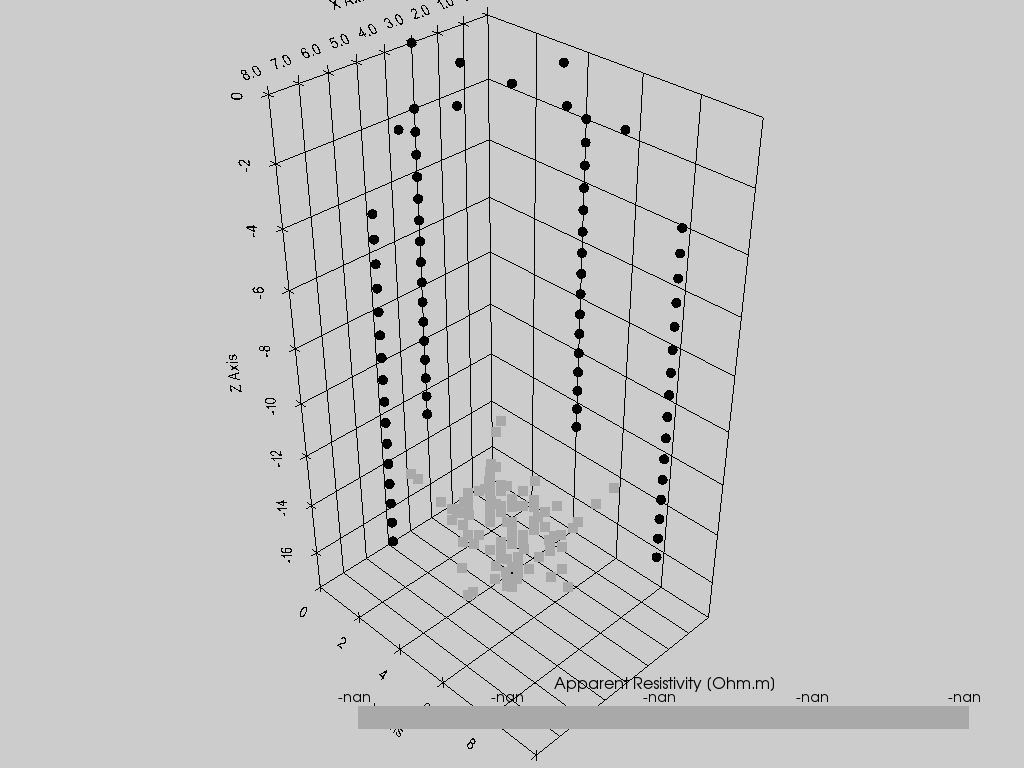

In [39]:
# the 3D pseudo-section is meaningless in this case as it's not a simple set of 2D lines
# it just allows to see the electrode positions
pl = pv.Plotter()
k.showPseudo(ax=pl, threed=True)

Creating tetrahedral mesh...found buried electrodes
fmd in gmshWrap.py: 15.733537
writing .geo to file completed, save location:
/media/jkl/data/phd/tmp/resipy/src/resipy/invdir

Reading mesh3d.msh
Gmsh version == 3.x
reading node coordinates...
Determining element type...Tetrahedra
Reading connection matrix...
ignoring 3452 elements in the mesh file, as they are not required for R2/R3t
Finished reading .msh file
interpolating topography onto mesh using triangulate interpolation...done
Done
ResIPy Estimated RAM usage = 0.516558 Gb
done


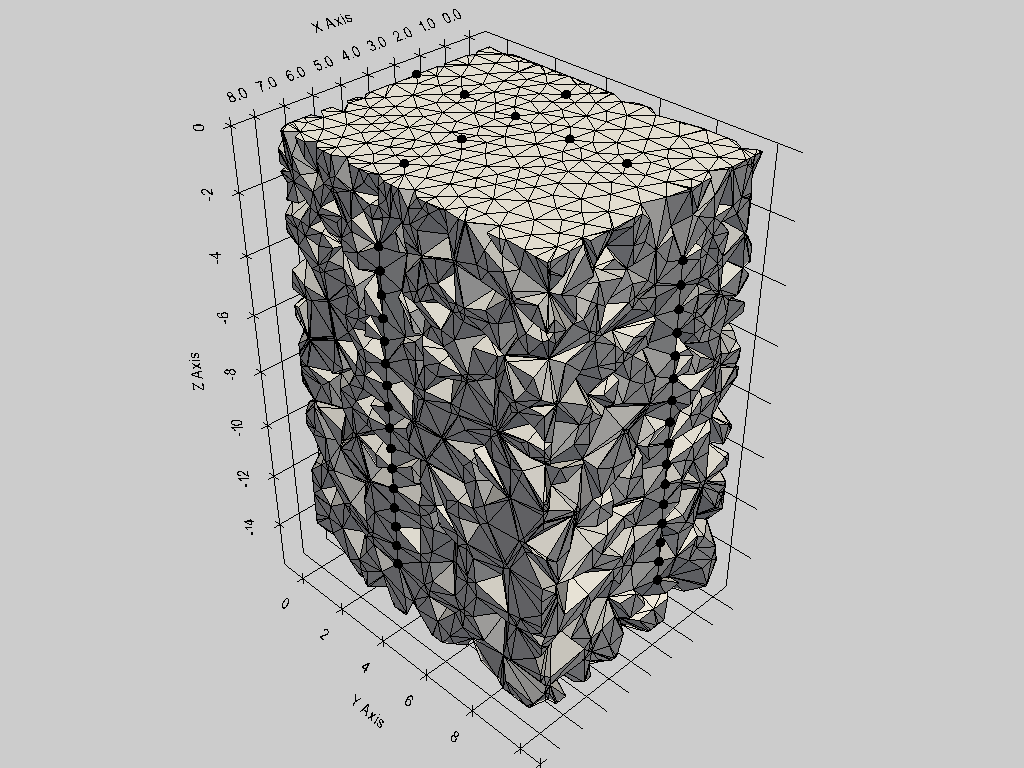

In [40]:
k.createMesh(cl=0.7)
pl = pv.Plotter()
k.showMesh(ax=pl, zlim=[-15, 0])

In [43]:
# need to save the entire mesh in order to compute difference manually
k.param['num_xy_poly'] = 0
k.param['zmin'] = -10e10

k.param['b_wgt'] = 0.05 # smaller values lead to overshooting and so no reg_mode == 1
k.param['reg_mode'] = 1 # background regularization
k.invert(parallel=True)

Writing .in file and protocol.dat... done!
------------ INVERTING REFERENCE SURVEY ---------------


 >> R 3 t     E R T    M o d e l    v2.01 <<

 >> Date: 01-09-2020
 >> My beautiful 3D survey                                                          
 >> I n v e r s e   S o l u t i o n   S e l e c t e d <<
 >> T e t r a h e d r a l   E l e m e n t   M e s h <<

 >> Reading mesh file 
 >> Determining storage needed for finite element conductance matrix
 >> Generating index array for finite element conductance matrix
 >> Reading resistivity model from res0.dat                                                                        

 >> L o g - D a t a   I n v e r s i o n <<
 >> N o r m a l   R e g u l a r i s a t i o n <<

 >> Memory estimates:
    For   1000 measurements the memory needed is:          0.170 Gb
    For   2000 measurements the memory needed is:          0.334 Gb
    For   5000 measurements the memory needed is:          0.827 Gb
    For  10000 measurements the memory ne

NOTES:
- no difference(percent) attribute available (not computed by R3t) as difference inversion is not available
- need reg_mode = 1 then!
- but k.computeDiff() doesn't work too .... maybe TODO

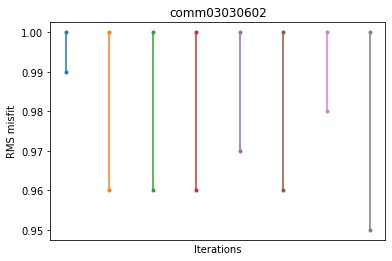

In [44]:
k.showRMS()

In [45]:
res0 = k.meshResults[0].df['Resistivity'].values
for m in k.meshResults[1:]:
    m.df['difference(percent)'] = (m.df['Resistivity'] - res0)/res0 * 100

empty mesh


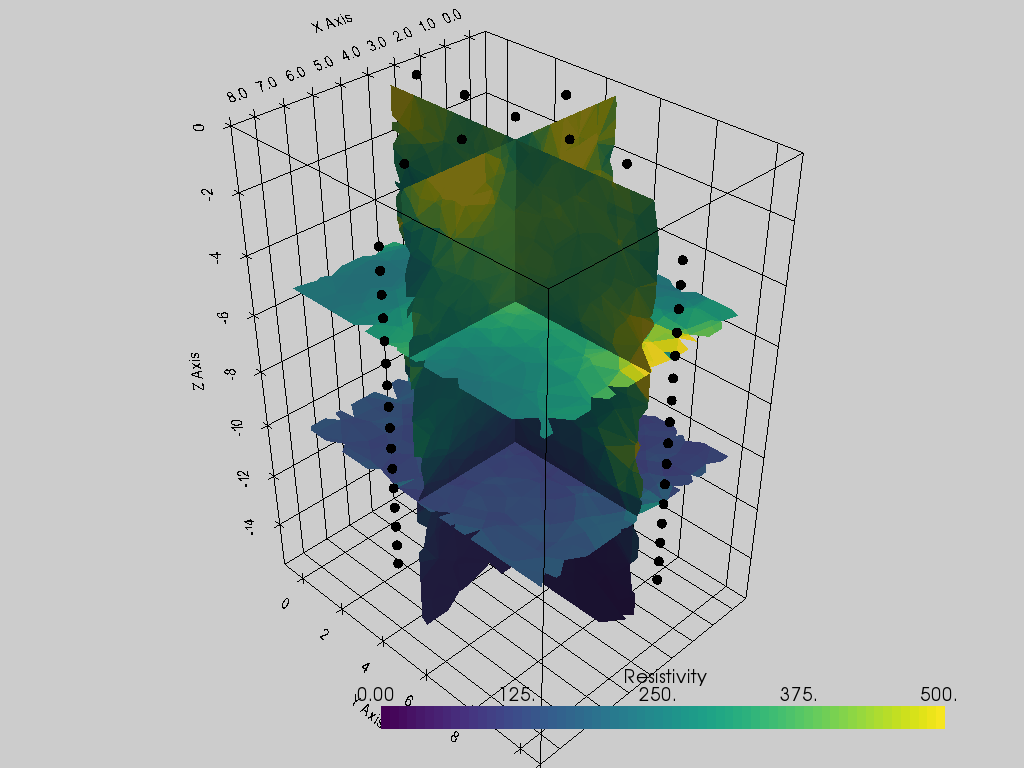

In [53]:
pl = pv.Plotter()
k.showResults(ax=pl, attr='Resistivity', index=0, 
              zlim=[-15, 0], pvslices=[[4],[5],[-5,-10,-15]], vmin=0, vmax=500)

empty mesh


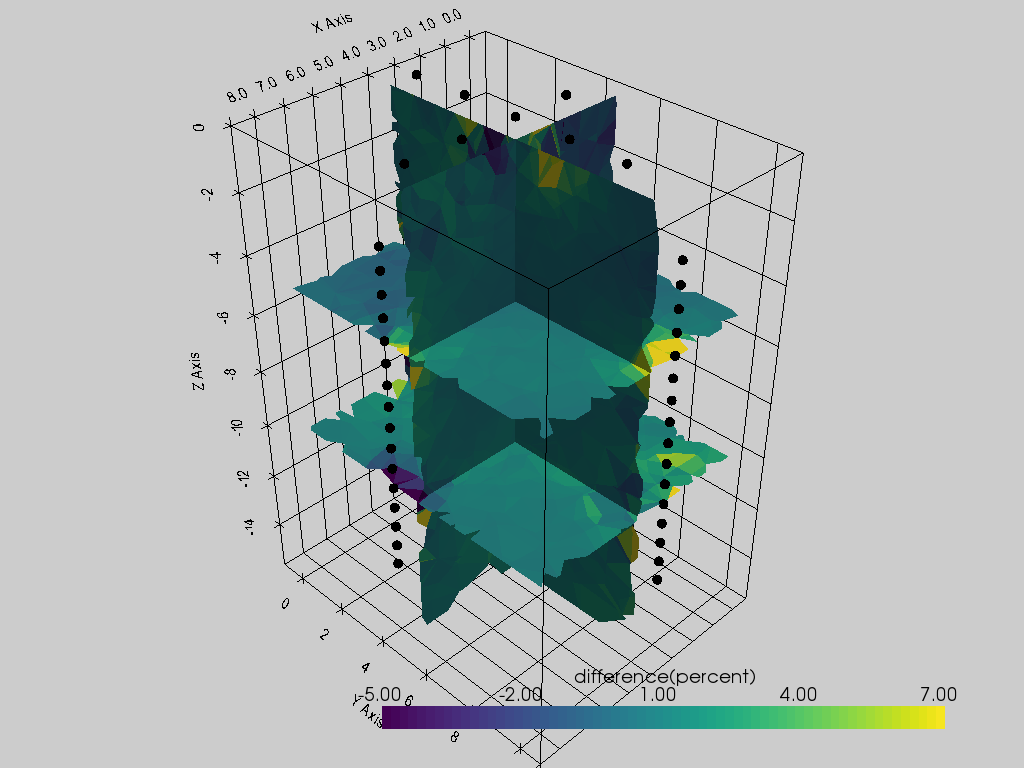

In [54]:
pl = pv.Plotter()
k.showResults(ax=pl, attr='difference(percent)', index=5, 
              zlim=[-15, 0], pvslices=[[4],[5],[-5,-10,-15]], vmin=-5, vmax=7)

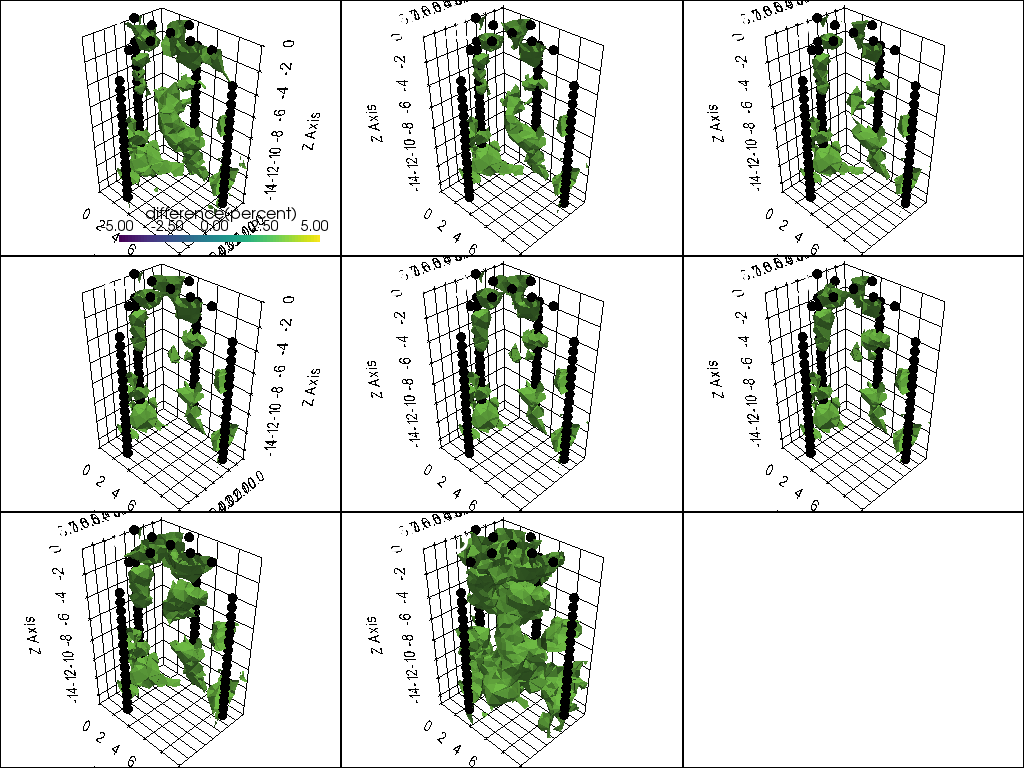

In [51]:
pl = pv.Plotter(shape=(3,3))
for i in range(3):
    for j in range(3):
        if i*3+j > 7:
            break
        pl.subplot(i, j)
        pl.add_text('Day {:d}'.format(i*3+j+1))
        k.showResults(index=i*3+j+1, ax=pl, attr='difference(percent)', background_color=(1,1,1),
                      zlim=[-15, 0], vmin=-5, vmax=5, pvcontour=[3], pvshow=False)
        # we need pvshow == False to build subplots(), this prevent calling Plotter.show()
        # after each scene
pl.show()

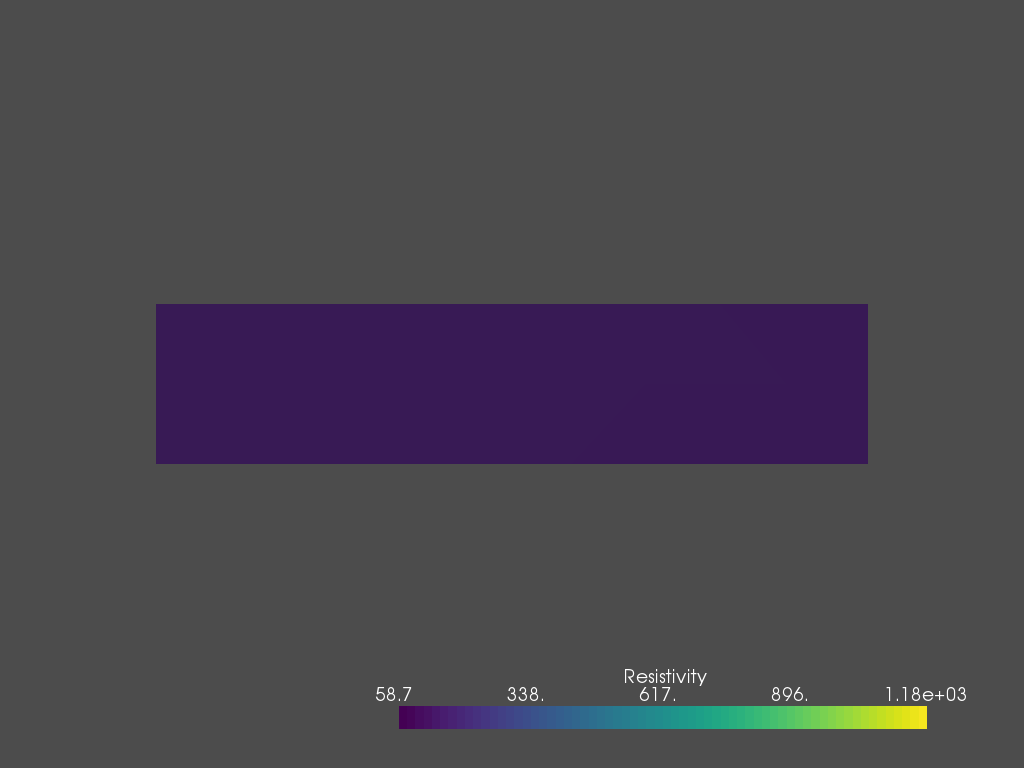

In [12]:
# graph
wd = k.dirname + '/'
a = 15
p = pv.Plotter(notebook=True)
for i in range(8):
    mesh = pv.read(wd + 'f{:03d}_res.vtk'.format(i+1))
    mesh.translate([a*i, 0, 0])
    p.add_mesh(mesh, scalars='Resistivity', cmap='viridis')
    melec = pv.PolyData(k.elec[['x','y','z']].values)
    melec.translate([a*i, 0, 0])
    p.add_mesh(melec)
p.view_xz()
p.show()
# add annotation